## Hidden Markov Model

In [1]:
import warnings
import logging
import itertools
import pandas as pd
import numpy as np
from pandas_datareader import data
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import argparse
import sys
import os
from datetime import timedelta

# Suppress warning in hmmlearn
warnings.filterwarnings("ignore")

In [2]:
class HMMStockPredictor:
    def __init__(
        self,
        company,
        start_date,
        end_date,
        future_days,
        test_size=0.20,
        n_hidden_states=4,
        n_latency_days=10,
        n_intervals_frac_change=50,
        n_intervals_frac_high=10,
        n_intervals_frac_low=10,
    ):
        self._init_logger()
        self.company = company
        self.start_date = start_date
        self.end_date = end_date
        self.n_latency_days = n_latency_days
        self.hmm = GaussianHMM(n_components=n_hidden_states)
        self._split_train_test_data(test_size)
        self._compute_all_possible_outcomes(
            n_intervals_frac_change, n_intervals_frac_high, n_intervals_frac_low
        )
        self.predicted_close = None
        self.days_in_future = future_days

    def _init_logger(self):
        self._logger = logging.getLogger(__name__)
        handler = logging.StreamHandler()
        formatter = logging.Formatter(
            "%(asctime)s %(name)-12s %(levelname)-8s %(message)s"
        )
        handler.setFormatter(formatter)
        self._logger.addHandler(handler)
        self._logger.setLevel(logging.DEBUG)

    def _split_train_test_data(self, test_size):
        """Downloads data and splits it into training and testing datasets."""
        # Use pandas_reader.data.DataReader to load the required financial data. Checks if the stock entry is valid.
        try:
            df_tics = pd.read_hdf("datasets/df_SnP_500_ohlcv.h5", "df", mode = 'r')
            used_data = df_tics[df_tics['tic'].isin([self.company])]
            used_data = used_data.drop(['tic'], axis=1)
            used_data = used_data.set_index('date')
            # used_data = data.DataReader(
            #     self.company, "yahoo", self.start_date, self.end_date
            # )
        except IOError:
            print(
                "Invalid stock selection. Please try again with a stock that is available on Yahoo finance."
            )
            sys.exit()
        # Do not shuffle the data as it is a time series
        _train_data, test_data = train_test_split(
            used_data, test_size=test_size, shuffle=False
        )
        self.train_data = _train_data
        self.test_data = test_data

        # Drop the columns that aren't used
        self.train_data = self.train_data.drop(["volume", "adj_close"], axis=1)
        self.test_data = self.test_data.drop(["volume", "adj_close"], axis=1)

        # Set days attribute
        self.days = len(test_data)

    @staticmethod
    def _extract_features(data):
        """Extract the features - open, close, high, low price - from the Yahooo finance generated dataframe."""
        open_price = np.array(data["open"])
        close_price = np.array(data["close"])
        high_price = np.array(data["high"])
        low_price = np.array(data["low"])

        # We compute the fractional change in high,low and close prices to use as our set of observations
        frac_change = (close_price - open_price) / open_price
        frac_high = (high_price - open_price) / open_price
        frac_low = (open_price - low_price) / open_price

        # Put the observations into one array
        return np.column_stack((frac_change, frac_high, frac_low))

    def fit(self):
        """Fit the continuous emission Gaussian HMM."""
        self._logger.info(">>> Extracting Features")
        observations = HMMStockPredictor._extract_features(self.train_data)
        self._logger.info("Features extraction Completed <<<")
        # Fit the HMM using the fit feature of hmmlearn
        self.hmm.fit(observations)

    def _compute_all_possible_outcomes(
        self, n_intervals_frac_change, n_intervals_frac_high, n_intervals_frac_low
    ):
        """Creates np arrays with evenly  spaced numbers for each range."""
        frac_change_range = np.linspace(-0.1, 0.1, n_intervals_frac_change)
        frac_high_range = np.linspace(0, 0.1, n_intervals_frac_high)
        frac_low_range = np.linspace(0, 0.1, n_intervals_frac_low)

        self._possible_outcomes = np.array(
            list(itertools.product(frac_change_range, frac_high_range, frac_low_range))
        )

    def _get_most_probable_outcome(self, day_index):
        """
        Using the fitted HMM, calculate the most probable outcome for a given day (e.g. prices will rise by 0.01).
        :param day_index: Current day index
        :return: The HMM's predicted movements in frac_change, frac_high, frac_low
        """
        # Use the previous n_latency_days worth of data for predictions
        previous_data_start_index = max(0, day_index - self.n_latency_days)
        previous_data_end_index = max(0, day_index - 1)
        previous_data = self.test_data.iloc[
            previous_data_start_index:previous_data_end_index
        ]
        previous_data_features = HMMStockPredictor._extract_features(previous_data)

        outcome_score = []

        # Score all possible outcomes and select the most probable one to use for prediction
        for possible_outcome in self._possible_outcomes:
            total_data = np.row_stack((previous_data_features, possible_outcome))
            outcome_score.append(self.hmm.score(total_data))

        # Get the index of the most probable outcome and return it
        most_probable_outcome = self._possible_outcomes[np.argmax(outcome_score)]

        return most_probable_outcome

    def predict_close_price(self, day_index):
        """Predict close price for a given day."""
        open_price = self.test_data.iloc[day_index]["open"]
        (
            predicted_frac_change,
            pred_frac_high,
            pred_frac_low,
        ) = self._get_most_probable_outcome(day_index)
        return open_price * (1 + predicted_frac_change)

    def predict_close_prices_for_period(self):
        """
        Predict close prices for the testing period.
        :return: List object of predicted close prices
        """
        predicted_close_prices = []
        print(
            "Predicting Close prices from "
            + str(self.test_data.index[0])
            + " to "
            + str(self.test_data.index[-1])
        )
        for day_index in tqdm(range(self.days)):
            predicted_close_prices.append(self.predict_close_price(day_index))
        self.predicted_close = predicted_close_prices
        return predicted_close_prices

    def real_close_prices(self):
        """ "Store and return the actual close prices."""
        actual_close_prices = self.test_data.loc[:, ["close"]]
        return actual_close_prices
    
    def real_open_prices(self):
        """ "Store and return the actual open prices."""
        actual_open_prices = self.test_data.loc[:, ["open"]]
        return actual_open_prices

    def add_future_days(self):
        """
        Add rows to the test data dataframe for the future days being predicted with accurate days. The rows are left
        with NaN values for now as they will be populated whilst predicting.
        """
        last_day = self.test_data.index[-1] + timedelta(days=self.days_in_future)

        # Create a new df with future days x days in the future based off the -f input. Concat the new df with
        # self.test_data.
        future_dates = pd.date_range(
            self.test_data.index[-1] + pd.offsets.DateOffset(1), last_day
        )
        second_df = pd.DataFrame(
            index=future_dates, columns=["high", "low", "open", "close"]
        )
        self.test_data = pd.concat([self.test_data, second_df])

        # Replace the opening price for the first day in the future with the close price of the previous day
        self.test_data.iloc[self.days,self.test_data.columns.get_loc("open")] = self.test_data.iloc[self.days - 1]["close"]

    def predict_close_price_fut_days(self, day_index):
        """
        Predict the close prices for the days in the future beyond the available data and populate the DF accordingly.
        :param day_index - index in DF for  current day being predicted.
        :return: Predicted close price for given day.
        """
        open_price = self.test_data.iloc[day_index,self.test_data.columns.get_loc("open")]

        # Calculate the most likely fractional changes using the trained HMM
        (
            predicted_frac_change,
            pred_frac_high,
            pred_frac_low,
        ) = self._get_most_probable_outcome(day_index)
        predicted_close_price = open_price * (1 + predicted_frac_change)

        # Fill in the dataframe based on predictions
        self.test_data.iloc[day_index]["close"] = predicted_close_price
        self.test_data.iloc[day_index]["high"] = open_price * (1 + pred_frac_high)
        self.test_data.iloc[day_index]["low"] = open_price * (1 - pred_frac_low)

        return predicted_close_price

    def predict_close_prices_for_future(self):
        """
        Calls the "predict_close_price_fut_days" function for each day in the future to predict future close prices.
        """
        predicted_close_prices = []
        future_indices = len(self.test_data) - self.days_in_future
        print(
            "Predicting future Close prices from "
            + str(self.test_data.index[future_indices])
            + " to "
            + str(self.test_data.index[-1])
        )

        # Iterate over only the final x days in the test data dataframe.
        for day_index in tqdm(range(future_indices, len(self.test_data))):
            predicted_close_prices.append(self.predict_close_price_fut_days(day_index))
            # Replace the next days Opening price (which is currently NaN) with the previous days predicted close price
            try:
                self.test_data.iloc[day_index + 1,self.test_data.columns.get_loc("open")] = predicted_close_prices[-1]
                # self.test_data.iloc[day_index + 1,self.test_data.columns.get_loc("open")] = self.test_data.iloc[day_index]["close"]
            except IndexError:
                continue

        # Return the predicted close prices
        self.predicted_close = predicted_close_prices

        return predicted_close_prices
    
def plot_results(in_df, out_dir, stock_name):
    """
    Plots the results for historical predictions
    :param in_df: Pandas Dataframe containing the data, actual close prices, and predicted close prices
    :param out_dir: Output directory
    :param stock_name: Stock name found in original input
    :return: Plot comparing the two sets of data is shown and saved.
    """
    in_df = in_df.reset_index()  # Required for plotting
    ax = plt.gca()
    in_df.plot(kind="line", x="date", y="Actual_Close", ax=ax)
    in_df.plot(kind="line", x="date", y="Predicted_Close", color="red", ax=ax)
    plt.ylabel("Daily Close Price (in USD)")
    plt.title(str(stock_name) + " daily closing stock prices")
    save_dir = f"{out_dir}/{stock_name}_results_plot.png"
    plt.savefig(save_dir)
    plt.show()
    plt.close("all")

def calc_mse(input_df):
    """
    Calculates the Mean Squared Error between real and predicted close prices
    :param input_df: Pandas Dataframe containing the data, actual close prices, and predicted close prices
    :return: Mean Squared Error
    """
    actual_arr = (input_df.loc[:, "Actual_Close"]).values
    pred_arr = (input_df.loc[:, "Predicted_Close"]).values
    mse = mean_squared_error(actual_arr, pred_arr)
    return mse

### Predict Stock Price

In [3]:
company_name = "GOOGL"
start = "2018-01-01"
end = "2023-10-10"
out_dir = "results/"
plot = True   # Optional: Boolean flag specifying if the results should be plotted or not."
future = 5    # Optional: Value specifying how far in the future the user would like predictions.
metrics = True   

'''Optional: Boolean flag specifying that the user would like to see how accurate the "
    "model is at predicting prices in the testing dataset for which real data exists, i.e. "
    "dates before -e. This slows down prediction as all test days will have their close "
    "prices predicted, as opposed to just the future days, but provides a metric to score "
    "the HMM (Mean Squared Error). ",'''


    # Handle empty input case
if not metrics and future is None:
    print(
        "No outputs selected as both historical predictions and future predictions are empty/None. Please repeat "
        "your inputs with a boolean value for -m, or an integer value for -f, or both."
    )
    sys.exit()

if out_dir is None:
    out_dir = os.getcwd()
else:
    out_dir = out_dir

In [4]:
company_name = company_name.strip("'").strip('"')
print(
    "Using continuous Hidden Markov Models to predict stock prices for "
    + str(company_name)
)

# Initialise HMMStockPredictor object and fit the HMM
stock_predictor = HMMStockPredictor(
    company=company_name, start_date=start, end_date=end, future_days=future
)
print(
    "Training data period is from "
    + str(stock_predictor.train_data.index[0])
    + " to "
    + str(stock_predictor.train_data.index[-1])
)
stock_predictor.fit()

2023-10-20 00:32:07,052 __main__     INFO     >>> Extracting Features


Using continuous Hidden Markov Models to predict stock prices for GOOGL
Training data period is from 2018-01-02 00:00:00 to 2022-08-19 00:00:00


2023-10-20 00:32:07,053 __main__     INFO     Features extraction Completed <<<


In [5]:
predicted_close = stock_predictor.predict_close_prices_for_period()

Predicting Close prices from 2022-08-22 00:00:00 to 2023-10-18 00:00:00


100%|██████████| 292/292 [05:29<00:00,  1.13s/it]


In [6]:
from sklearn.metrics import accuracy_score

All predictions saved. The Mean Squared Error for the 292 days considered is: 3.098816401450912 directional accuracy is 54.11


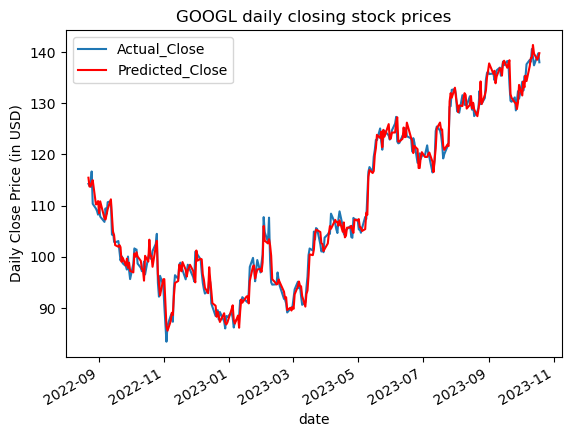

In [7]:
# Get the predicted and actual stock prices and create a DF for saving if you'd like to get a metric for the model
if metrics:

    actual_close = stock_predictor.real_close_prices()

    actual_close["Predicted_Close"] = predicted_close
    actual_close["Actual_Open"] = stock_predictor.real_open_prices()
    output_df = actual_close.rename(columns={"close": "Actual_Close"})
    output_df['actual_change'] =  output_df["Actual_Open"] - output_df["Actual_Close"]
    output_df['actual_direction'] = np.where(output_df['actual_change'] > 0, -1, 1) 
    y_true = np.array(output_df['actual_direction'])
    output_df['predicted_change'] =  output_df["Actual_Open"] - output_df["Predicted_Close"]
    output_df['predicted_direction'] = np.where(output_df['predicted_change'] > 0, -1, 1) 
    y_pred = np.array(output_df['predicted_direction'])
    # output_df['predicted_direction'] = output_df['predicted_change'].apply(f, axis=1)
    # Calculate Mean Squared Error and save
    mse = calc_mse(output_df)
    dir_acc = accuracy_score(y_true, y_pred)
    out_name = f"{out_dir}/{company_name}_HMM_Prediction_{str(round(mse, 6))}.xlsx"
    output_df.to_excel(out_name)  # Requires openpyxl installed
    print(
        "All predictions saved. The Mean Squared Error for the "
        + str(stock_predictor.days)
        + " days considered is: "
        + str(mse)
        + " directional accuracy is "
        + str(100*round(dir_acc,4))
    )

    # Plot and save results if plot is True
    if plot:
        plot_results(output_df, out_dir, company_name)

In [8]:
# # Predict for x days into the future
# if future:
#     stock_predictor.add_future_days()
#     future_pred_close = stock_predictor.predict_close_prices_for_future()

#     print(
#         "The predicted stock prices for the next "
#         + str(future)
#         + " days from "
#         + str(stock_predictor.end_date)
#         + " are: ",
#         future_pred_close,
#     )

#     out_final = (
#         f"{out_dir}/{company_name}_HMM_Predictions_{future}_days_in_future.xlsx"
#     )
#     stock_predictor.test_data.to_excel(out_final)  # Requires openpyxl installed
#     print(
#         "The full set of predictions has been saved, including the High, Low, Open and Close prices for "
#         + str(future)
#         + " days in the future."
#     )